In [170]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)

In [171]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)
#from keras import models
#from keras import layers
#from keras.layers.experimental import preprocessing

from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

2.3.1


In [172]:
#Paramètres
traintest_split=0.7
validation_split=0.3
num_classes=3
n_neurons_hiddenlayer=2
n_epochs=300

In [173]:
#Import du jeu de données wine en ligne avec pandas
data_file= 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
column_names = ['class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
                'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue','OD280 OD315 of diluted wines','Proline']
raw_dataset = pd.read_csv(data_file, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)

In [174]:
#Mise en forme
dataset = raw_dataset.copy()
dataset.tail()
dataset.isna().sum()
dataset = dataset.dropna()

In [175]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='') # Intérêt ?
dataset.tail()

class  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
173      3    13.71        5.65  2.45               20.5         95   
174      3    13.40        3.91  2.48               23.0        102   
175      3    13.27        4.28  2.26               20.0        120   
176      3    13.17        2.59  2.37               20.0        120   
177      3    14.13        4.10  2.74               24.5         96   

     Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
173           1.68        0.61                  0.52             1.06   
174           1.80        0.75                  0.43             1.41   
175           1.59        0.69                  0.43             1.35   
176           1.65        0.68                  0.53             1.46   
177           2.05        0.76                  0.56             1.35   

     Color intensity   Hue  OD280 OD315 of diluted wines  Proline  
173              7.7  0.64                          1.74      740  
174              7.3  0.70                          1.56      750  
175             10.2  0.59                          1.56      835  
176              9.3  0.60                          1.62      840  
177              9.2  0.61                          1.60      560

In [176]:
#Séparation apprentissage test
train_dataset = dataset.sample(frac=traintest_split, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
#On élimine la variable à prédire (class)
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('class')
test_labels = test_features.pop('class')
# Vérification des dimensions
print(train_features.shape)
print(test_features.shape)
print(train_labels)
print(test_labels.shape)

(125, 13)
(53, 13)
54     1
151    3
63     2
55     1
123    2
      ..
119    2
102    2
35     1
57     1
41     1
Name: class, Length: 125, dtype: int64
(53,)


In [193]:
features=['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue','OD280 OD315 of diluted wines','Proline']
#x = dataset.loc[:,features].values
#y = dataset.loc[:,['class']].values
#dataset.pop('class') -> lequel est le mieux

In [177]:
# ACP sous python = réduction de dimension
from sklearn.decomposition import PCA

# d'abord centrer - réduire en divisant par l'écart-type
sc = StandardScaler()
sc.fit(train_features)

# apply transform
train_features = sc.transform(train_features)
test_features = sc.transform(test_features)

# idem pour ACP
pca = PCA(n_components=2)
pca.fit(train_features)

train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print(train_features.shape)

(125, 2)


In [178]:
# Visualisation
principalDF = pd.DataFrame(data=train_features, columns = ['PC1','PC2'])
principalDF.index = train_labels.index
#print(train_labels.index)
finalDF = pd.concat([principalDF,train_labels],axis=1)
finalDF.tail()

PC1       PC2  class
119  0.801816 -2.143101      2
102  0.308499 -1.041170      2
35  -1.778433  0.163212      1
57  -2.050050  1.144205      1
41  -0.505229  0.052390      1

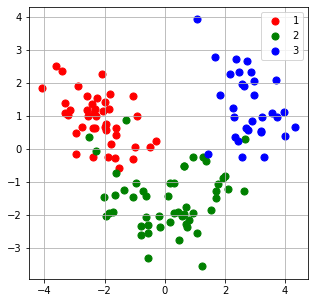

In [179]:
# représentation des données dans le plan 1-2
fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
classes = [1,2,3]
colors=['r','g','b']
for target, color in zip(classes,colors):
    indicesToKeep = finalDF['class'] == target
    ax.scatter(finalDF.loc[indicesToKeep, 'PC1'], finalDF.loc[indicesToKeep, 'PC2'],
              c=color,
              s=50)
ax.legend(classes)
ax.grid()

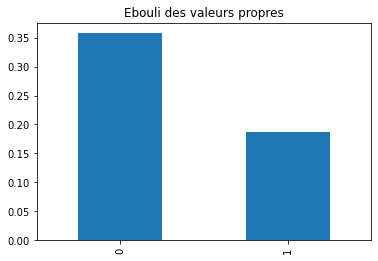

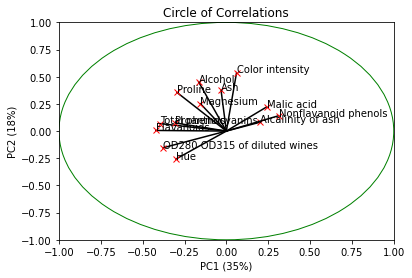

In [204]:
# info complémentaire
ebouli = pd.Series(pca.explained_variance_ratio_)
ebouli.plot(kind='bar', title="Ebouli des valeurs propres")
plt.show()

coef = np.transpose(pca.components_)
cols = ['PC'+str(x) for x in range(len(ebouli))]
pc_infos = pd.DataFrame(coef, columns=cols, index=features)

plt.Circle((0,0),radius=10, color='g', fill=False)
circle1=plt.Circle((0,0),radius=1, color='g', fill=False)
fig = plt.gcf()
fig.gca().add_artist(circle1)
for idx in range(len(pc_infos["PC0"])):
	x = pc_infos["PC0"][idx]
	y = pc_infos["PC1"][idx]
	plt.plot([0.0,x],[0.0,y],'k-')
	plt.plot(x, y, 'rx')
	plt.annotate(pc_infos.index[idx], xy=(x,y))
plt.xlabel("PC1 (%s%%)" % str(ebouli[0])[:4].lstrip("0."))
plt.ylabel("PC2 (%s%%)" % str(ebouli[1])[:4].lstrip("0."))
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.title("Circle of Correlations")
plt.show()

#(fig, ax) = plt.subplots(figsize=(6,6))
#for i in range(0, len(pca.components_[0])):
#    ax.arrow(0,0,
#            pca.components_[0,i], pca.components_[1,i],
#            head_width = 0.01, head_length = 0.1)
#print(pca.explained_variance_ratio_)

In [7]:
#Normalisation
#scaler = MinMaxScaler(feature_range=(-1,1)) # intérêt par rapport à Standard Scaler ?
#scaler.fit(train_features)
# apply transform
#train_features = scaler.transform(train_features)
#test_features = scaler.transform(test_features)

In [181]:
#Fonction de construction du modèle
def build_model():
    model = Sequential()
    model.add(Dense(n_neurons_hiddenlayer, activation='relu', input_shape=(train_features.shape[1],),name='hidden'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 2)                 6         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 9         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [182]:
#Entrainement du modèle
#Important: to_categorical permet d'encoder la classe au format one hot encoding
history=model.fit(train_features, to_categorical(train_labels-1), epochs=n_epochs, verbose=0, validation_split=validation_split) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


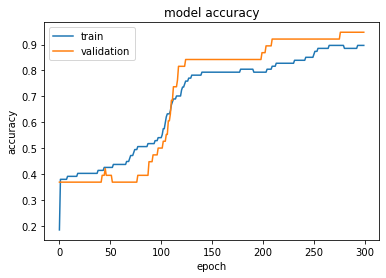

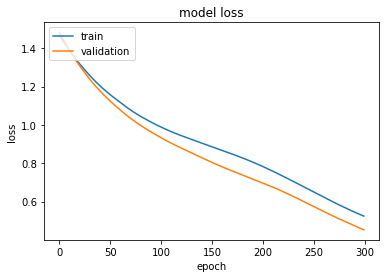

In [183]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [184]:
#Application au jeu de test
predicted = model.predict(test_features)
print(predicted)
#Argmax pour passer de one hot encoding à numéro de classe
predicted = np.argmax(predicted, axis=1)
print(predicted)
print("Prédiction de test")
accuracy_score(test_labels-1, predicted)

[[0.212 0.6   0.188]
 [0.636 0.088 0.276]
 [0.728 0.013 0.259]
 [0.492 0.225 0.284]
 [0.624 0.035 0.341]
 [0.666 0.066 0.268]
 [0.457 0.264 0.279]
 [0.756 0.021 0.224]
 [0.45  0.273 0.277]
 [0.613 0.106 0.281]
 [0.603 0.115 0.282]
 [0.196 0.625 0.179]
 [0.765 0.018 0.217]
 [0.704 0.043 0.252]
 [0.593 0.124 0.284]
 [0.76  0.009 0.231]
 [0.784 0.012 0.204]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.173 0.632 0.194]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.196 0.625 0.179]
 [0.145 0.639 0.215]
 [0.196 0.625 0.179]
 [0.101 0.412 0.487]
 [0.147 0.43  0.423]
 [0.155 0.265 0.58 ]
 [0.121 0.302 0.576]
 [0.117 0.224 0.658]
 [0.151 0.272 0.577]
 [0.08  0.07  0.85 ]
 [0.118 0.043 0.839]
 [0.107 0.025 0.868]
 [0.143 0.014 0.843]
 [0.116 0.312 0.572]
 [0.084 0.036

0.9433962264150944

In [185]:
# Extraction et visualisation de la matrice des poids et du vecteur des biais (si utilisés) pour toutes les couches
for layer in model.layers: print(layer.get_weights())

[array([[ 0.523, -0.164],
       [ 0.775,  1.376]], dtype=float32), array([-0.041,  0.714], dtype=float32)]
[array([[-0.99 , -0.255,  0.107],
       [ 0.02 , -1.61 , -0.367]], dtype=float32), array([-0.435,  0.723, -0.524], dtype=float32)]


(125, 2)


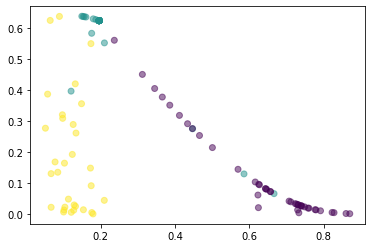

In [186]:
#Extraction des activations pour une couche intermédiare
layer_name = 'hidden'
extractor =  keras.Model(inputs=model.inputs,
                        outputs=[layer.output for layer in model.layers])
intermediate_output = extractor.predict(train_features)
print(intermediate_output[0].shape)

#Représentation des activations de deux neurones cachés dans un plan 2D en fonction de la classe
plt.scatter(intermediate_output[1][:,0], intermediate_output[1][:,1], c=train_labels, alpha=0.5)